In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_score, silhouette_samples
import umap
import matplotlib.pyplot as plt
from itertools import product
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import calculate_scores as cal

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## UMAP Hyperparameters is optimized

In [2]:
train = pd.read_csv("CIBM_Journal_Training_Unbalanced_27_HbA1C.csv")

In [3]:
train_data = train.iloc[:,1:28]
train_label = train.label

scaler = StandardScaler()
train_data_normalized = scaler.fit_transform(train_data)

umap_model = umap.UMAP(n_neighbors=7,
                           min_dist=0,
                           n_components=2,
                           random_state=3,
                           metric='euclidean')
X_reduced = umap_model.fit_transform(train_data_normalized)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [4]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull
import numpy as np

# Assuming X_reduced and train_label are defined as in your data
train_healthy_color = "blue"
train_T1D_color = "red"

# Your scatter plot
plt.figure(dpi=320)
plt.scatter(X_reduced[train_label == 1, 0], X_reduced[train_label == 1, 1], s=0.05, alpha = 0.5, c=train_T1D_color, label='T1D')
plt.scatter(X_reduced[train_label == 0, 0], X_reduced[train_label == 0, 1], s=0.05, alpha = 0.5, c=train_healthy_color, label='Healthy Control')

# Calculate and plot filled Convex Hull for the first cluster
points_1 = X_reduced[train_label == 1]
hull_1 = ConvexHull(points_1)
# plt.fill(points_1[hull_1.vertices, 0], points_1[hull_1.vertices, 1], 'red', alpha=0.2)

# Calculate and plot filled Convex Hull for the second cluster
points_0 = X_reduced[train_label == 0]
hull_0 = ConvexHull(points_0)
# plt.fill(points_0[hull_0.vertices, 0], points_0[hull_0.vertices, 1], 'blue', alpha=0.1)

# Calculate and plot centroids for each class
centroid_1 = np.mean(points_1, axis=0)
centroid_0 = np.mean(points_0, axis=0)

# Plotting centroids, you can adjust the size (s) and color as needed
plt.scatter(centroid_1[0], centroid_1[1], s=50, c=train_T1D_color, edgecolors="black", marker="*", label='Centroid T1D')
plt.scatter(centroid_0[0], centroid_0[1], s=50, c=train_healthy_color, edgecolors="black", marker="*", label='Centroid Healthy')

# Custom legend entries
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=train_T1D_color, markersize=3, label='T1D'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=train_healthy_color, markersize=3, label='Healthy Control'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=train_T1D_color, markeredgecolor='black', markersize=4, label='Centroid T1D'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=train_healthy_color, markeredgecolor='black', markersize=4, label='Centroid Healthy')
]

# Add legend to the plot with custom markers
plt.legend(handles=legend_elements, markerscale=2, fontsize=7,frameon=False)
plt.title("UMAP of computed glycemic features on training dataset")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.savefig('UMAP for training.jpg', format='jpg', dpi=1200, bbox_inches='tight')
# Uncomment the following line if you want to display the plot inline (e.g., in a Jupyter notebook)
plt.show()


### For SS for training

In [5]:
from scipy.stats import pearsonr
print(f"silhouette_score: {silhouette_score(X_reduced, train_label, metric='euclidean')}")
distance_to_centroid = []
diabetic_or_not = 1
for point in tqdm(X_reduced[train_label == diabetic_or_not,:]):
    silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
    distance_to_centroid.append(silhouette_score_single)
    
correlation, p_value = pearsonr(distance_to_centroid, train.loc[train_label == diabetic_or_not,:].HbA1c)
print(f"Pearson's correlation: {np.round(correlation, 4)}, P-value: {p_value}")

silhouette_score: 0.2922809422016144


100%|███████████████████████████████████████████████████████████████████████████| 39738/39738 [01:28<00:00, 447.01it/s]

Pearson's correlation: -0.3961, P-value: 0.0


In [18]:
distance_to_centroid = np.array(distance_to_centroid)
HbA1c_values = train.loc[train_label == diabetic_or_not, :].HbA1c.to_numpy()

# Original Pearson correlation
correlation, original_p_value = pearsonr(distance_to_centroid, HbA1c_values)
print(f"Original Pearson's correlation: {np.round(correlation, 4)}, Original P-value: {original_p_value:.2e}")

# Bootstrapping to estimate p-value
n_bootstraps = 10000
bootstrapped_correlations = np.zeros(n_bootstraps)
for i in tqdm(range(n_bootstraps)):
    indices = np.random.choice(len(distance_to_centroid), len(distance_to_centroid), replace=True)
    bootstrapped_correlation, _ = pearsonr(distance_to_centroid[indices], HbA1c_values[indices])
    bootstrapped_correlations[i] = bootstrapped_correlation

# Calculating bootstrapped p-value
extreme_correlations = np.sum(np.abs(bootstrapped_correlations) >= np.abs(correlation))
bootstrapped_p_value = extreme_correlations / n_bootstraps

print(f"Bootstrapped Pearson's correlation: {np.round(correlation, 4)}, Bootstrapped P-value: {bootstrapped_p_value:.2e}")

Original Pearson's correlation: -0.3765, Original P-value: 0.00e+00


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 311.05it/s]

Bootstrapped Pearson's correlation: -0.3765, Bootstrapped P-value: 4.94e-01


In [6]:
distance_to_centroid = []
diabetic_or_not = 0
for point in tqdm(X_reduced[train_label == diabetic_or_not,:]):
    silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
    distance_to_centroid.append(silhouette_score_single)
    
correlation, p_value = pearsonr(distance_to_centroid, train.loc[train_label == diabetic_or_not,:].Age)
print(f"Healthy Pearson's correlation: {np.round(correlation, 4)}, P-value: {p_value}")

distance_to_centroid = []
diabetic_or_not = 1
for point in tqdm(X_reduced[train_label == diabetic_or_not,:]):
    silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
    distance_to_centroid.append(silhouette_score_single)
    
correlation, p_value = pearsonr(distance_to_centroid, train.loc[train_label == diabetic_or_not,:].Age)
print(f"Diabete Pearson's correlation: {np.round(correlation, 4)}, P-value: {p_value}")

100%|███████████████████████████████████████████████████████████████████████████████| 716/716 [00:01<00:00, 412.49it/s]


Healthy Pearson's correlation: -0.2017, P-value: 5.204853097772563e-08


100%|███████████████████████████████████████████████████████████████████████████| 39738/39738 [01:44<00:00, 379.80it/s]

Diabete Pearson's correlation: 0.0277, P-value: 3.434815276514971e-08


In [22]:
distance_to_centroid = []
diabetic_or_not = 0
for point in tqdm(X_reduced[train_label == diabetic_or_not,:]):
    silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
    distance_to_centroid.append(silhouette_score_single)

BMI = train.loc[train_label == diabetic_or_not,:].Weight/((train.loc[train_label == diabetic_or_not,:].Height/100)**2)
correlation, p_value = pearsonr(distance_to_centroid, BMI)
print(f"Healthy Pearson's correlation: {np.round(correlation, 4)}, P-value: {p_value}")

distance_to_centroid = []
diabetic_or_not = 1
for point in tqdm(X_reduced[train_label == diabetic_or_not,:]):
    silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
    distance_to_centroid.append(silhouette_score_single)
    
BMI = train.loc[train_label == diabetic_or_not,:].Weight/((train.loc[train_label == diabetic_or_not,:].Height/100)**2)
correlation, p_value = pearsonr(distance_to_centroid, BMI)
print(f"Diabete Pearson's correlation: {np.round(correlation, 4)}, P-value: {p_value}")

100%|███████████████████████████████████████████████████████████████████████████████| 716/716 [00:02<00:00, 308.51it/s]


Healthy Pearson's correlation: -0.1542, P-value: 3.4292575532234544e-05


100%|███████████████████████████████████████████████████████████████████████████| 39738/39738 [01:47<00:00, 368.10it/s]

Diabete Pearson's correlation: -0.1062, P-value: 4.795469374331723e-100


In [17]:
import numpy as np
from scipy.stats import mannwhitneyu
from scipy import stats

distance_to_centroid = []
diabetic_or_not = 0
for point in tqdm(X_reduced[train_label == diabetic_or_not,:]):
    silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
    distance_to_centroid.append(silhouette_score_single)
diabetic_or_not_data = train.loc[train_label == diabetic_or_not,:]

distance_to_centroid = np.array(distance_to_centroid)

# Example data for two groups
group1 = distance_to_centroid[diabetic_or_not_data.Gender.values == 'F']  # e.g., data for males
group2 = distance_to_centroid[diabetic_or_not_data.Gender.values == 'M']  # e.g., data for females

# Perform the independent samples t-test
t_statistic, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

# Print the results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the two groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two groups.")

ks_stat, ks_p_value = stats.ks_2samp(group1, group2)
print(f'Kolmogorov-Smirnov Test: statistic={ks_stat}, p-value={ks_p_value}')


distance_to_centroid = []
diabetic_or_not = 1
for point in tqdm(X_reduced[train_label == diabetic_or_not,:]):
    silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
    distance_to_centroid.append(silhouette_score_single)
diabetic_or_not_data = train.loc[train_label == diabetic_or_not,:]

distance_to_centroid = np.array(distance_to_centroid)

# Example data for two groups
group1 = distance_to_centroid[diabetic_or_not_data.Gender.values == 'F']  # e.g., data for males
group2 = distance_to_centroid[diabetic_or_not_data.Gender.values == 'M']  # e.g., data for females

# Perform the independent samples t-test
t_statistic, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

# Print the results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the two groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two groups.")

ks_stat, ks_p_value = stats.ks_2samp(group1, group2)
print(f'Kolmogorov-Smirnov Test: statistic={ks_stat}, p-value={ks_p_value}')

100%|███████████████████████████████████████████████████████████████████████████████| 716/716 [00:01<00:00, 390.33it/s]


T-statistic: 53917.0
P-value: 0.20428248529168014
Fail to reject the null hypothesis: There is no significant difference between the two groups.
Kolmogorov-Smirnov Test: statistic=0.11290674819829657, p-value=0.030694255702536803


100%|███████████████████████████████████████████████████████████████████████████| 39738/39738 [01:50<00:00, 360.14it/s]


T-statistic: 185411726.5
P-value: 1.2540070288071953e-24
Reject the null hypothesis: There is a significant difference between the two groups.
Kolmogorov-Smirnov Test: statistic=0.05974433072224783, p-value=3.173951695712095e-31


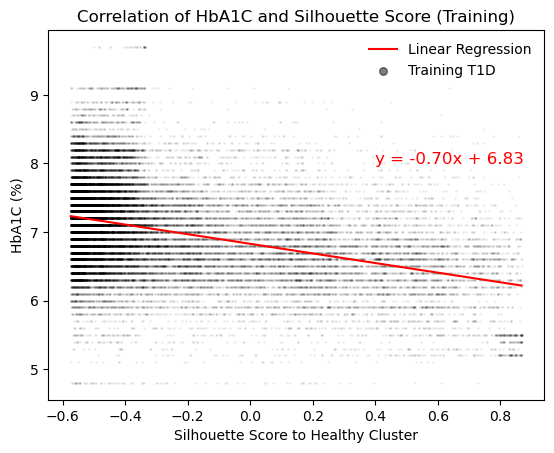

In [24]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Your code setup here...
# Make sure to replace this with your actual data setup
# distance_to_centroid, train, train_label, diabetic_or_not should be defined prior to this

plt.scatter(np.array(distance_to_centroid), train.loc[train_label == diabetic_or_not,:].HbA1c, s=1, c="k",alpha=0.05)

filtered_data = train.loc[train_label == diabetic_or_not,:].HbA1c
filtered_distances = np.array(distance_to_centroid)
model = LinearRegression()
model.fit(filtered_distances.reshape(-1, 1), filtered_data)

x_range = np.linspace(filtered_distances.min(), filtered_distances.max(), 100).reshape(-1, 1)
y_pred = model.predict(x_range)
plt.plot(x_range, y_pred, color='red', label='Linear Regression')

eq_text = f'y = {model.coef_[0]:.2f}x + {model.intercept_:.2f}'
plt.text(0.4, 8, eq_text, fontsize=12, color='red')

# Add an invisible scatter plot with larger marker size for the legend
plt.scatter([], [], s=30, color='k', alpha=0.5, label="Training T1D")  # Adjust `s` as needed

plt.xlabel("Silhouette Score to Healthy Cluster")
plt.ylabel("HbA1C (%)")
plt.title("Correlation of HbA1C and Silhouette Score (Training)")

# Create the legend. You might need to adjust `markerscale` if you use it in conjunction with other markers
plt.legend(frameon=False)
plt.savefig('training_result.jpg', format='jpg', dpi=1200, bbox_inches='tight')
plt.show()


In [11]:
def process_demo(df,X_reduced,X_reduced_val):
    train=df
    demographic = train[['HbA1c', 'Age', 'Gender', 'label']]
    demographic["unique_id"] = [number.split('_')[0]+"_"+number.split('_')[1]+number.split('_')[2] for number in train.id]
    
    if "BMI" in train.columns:
        demographic["BMI"] = train["BMI"]
    else:
        demographic["BMI"] = train["Weight"]/((train["Height"]/100)**2)
    distance_to_centroid = []
    diabetic_or_not = 1
    for point in tqdm(X_reduced_val):
        silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
        distance_to_centroid.append(silhouette_score_single)
    
    demographic["Silhouette Score"] = distance_to_centroid
    demographic['Gender'] = demographic['Gender'].replace({"M": 0, "F": 1})
    
    train_race = pd.DataFrame()
    train_race['Race'] = train['Race']
    train_race['unique_id'] = [number.split('_')[0]+"_"+number.split('_')[1]+number.split('_')[2] for number in train.id]
    train_race.drop_duplicates(subset="unique_id",inplace=True)
    final = pd.merge(demographic.groupby("unique_id").median().reset_index(), train_race, on="unique_id")
    final['Gender'] = final['Gender'].replace({0: "M", 1: "F"})
    final["dataset"] = [number.split('_')[0] for number in final.unique_id]
    return final

In [182]:
demo1 = process_demo(train,X_reduced,X_reduced)
demo1

C:\Users\sjfsj\AppData\Local\Temp\ipykernel_4476\134291472.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic["unique_id"] = [number.split('_')[0]+"_"+number.split('_')[1]+number.split('_')[2] for number in train.id]
C:\Users\sjfsj\AppData\Local\Temp\ipykernel_4476\134291472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic["BMI"] = train["Weight"]/((train["Height"]/100)**2)
100%|███████████████████████████████████████████████████████████████████████████| 40454/40454 [01:28<00:00,

,unique_id,HbA1c,Age,Gender,label,BMI,Silhouette Score,Race,dataset
0,Ale_T1D10,5.4,63.0,F,1.0,24.740937,0.832627,White,Ale
1,Ale_T1D101,5.7,27.0,M,1.0,22.395413,0.150254,White,Ale
2,Ale_T1D102,7.4,64.0,M,1.0,27.288733,-0.541539,White,Ale
3,Ale_T1D103,7.3,57.0,M,1.0,25.492304,-0.492429,White,Ale
4,Ale_T1D105,7.9,42.0,F,1.0,23.479290,-0.498694,White,Ale
...,...,...,...,...,...,...,...,...,...
372,Shah_healthy95,5.2,21.0,F,0.0,23.979239,0.834930,White,Shah
373,Shah_healthy96,4.8,19.0,F,0.0,25.524260,0.862269,More than one race,Shah
374,Shah_healthy97,4.7,20.0,F,0.0,19.372933,0.788143,White,Shah
375,Shah_healthy98,5.1,21.0,M,0.0,23.334877,0.860827,White,Shah


In [12]:
val = pd.read_csv("CIBM_Journal_Validation_Unbalanced_27_HbA1C.csv")
# val.dropna(inplace=True)
val.reset_index(drop=True)
val_T1D = val[val.label==1]
val.loc[val.label==1, "BMI"] = val.loc[val.label==1, "Weight"] / ((val.loc[val.label==1, "Height"]/100)**2)

val_data = val.iloc[:,1:28]
val_label = val.label
val_data_normalized = scaler.transform(val_data)
X_reduced_val = umap_model.transform(val_data_normalized)
demo2 = process_demo(val,X_reduced,X_reduced_val)

C:\Users\sjfsj\AppData\Local\Temp\ipykernel_3804\1139648561.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic["unique_id"] = [number.split('_')[0]+"_"+number.split('_')[1]+number.split('_')[2] for number in train.id]
C:\Users\sjfsj\AppData\Local\Temp\ipykernel_3804\1139648561.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic["BMI"] = train["BMI"]
100%|███████████████████████████████████████████████████████████████████████████| 22297/22297 [00:52<00:00, 423.73it/s]
C:\Users\sjfsj\

In [189]:
all_demo = pd.concat([demo1,demo2]).reset_index(drop=True)
all_demo.drop(columns = ["unique_id","label"],inplace=True)
all_demo

,HbA1c,Age,Gender,BMI,Silhouette Score,Race,dataset
0,5.4,63.0,F,24.740937,0.832627,White,Ale
1,5.7,27.0,M,22.395413,0.150254,White,Ale
2,7.4,64.0,M,27.288733,-0.541539,White,Ale
3,7.3,57.0,M,25.492304,-0.492429,White,Ale
4,7.9,42.0,F,23.479290,-0.498694,White,Ale
...,...,...,...,...,...,...,...
799,7.6,15.0,M,24.489796,-0.496393,White,Tam
800,7.1,45.0,M,25.179642,0.063340,White,Tam
801,7.4,13.0,M,20.626214,-0.474237,More than one race,Tam
802,7.4,51.0,F,25.490902,-0.294951,White,Tam


In [196]:
all_demo = pd.concat([demo1,demo2]).reset_index(drop=True)
all_demo[all_demo.drop(columns = ["Race"]).isna().any(axis=1)]

,unique_id,HbA1c,Age,Gender,label,BMI,Silhouette Score,Race,dataset
465,Colas_Healthy79,5.8,NaN,NaN,0.0,NaN,0.849748,NaN,Colas
473,Colas_Healthy92,5.7,72.0,F,0.0,NaN,0.442470,NaN,Colas
617,Tam_T1D303,NaN,18.0,F,1.0,25.890105,-0.476151,White,Tam


In [190]:
from tableone import TableOne
categorical = ['Race', 'Gender']
groupby = ['dataset']
# nonnormal = ['Age']
mytable = TableOne(all_demo, categorical=categorical,groupby=groupby,pval=False)

D:\Anaconda\Lib\site-packages\tableone\tableone.py:927: FutureWarning: The provided callable <function mean at 0x00000253EF8DC2C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_cont = pd.pivot_table(cont_data,
D:\Anaconda\Lib\site-packages\tableone\tableone.py:927: FutureWarning: The provided callable <function median at 0x00000253EFA0FD80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_cont = pd.pivot_table(cont_data,
D:\Anaconda\Lib\site-packages\tableone\tableone.py:927: FutureWarning: The provided callable <built-in function min> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df_cont = pd.p

In [306]:
mytable

Grouped by dataset                                                                 
                                                              Missing      Overall          Ale        Colas         Shah          Tam
n                                                                              804          226           99          151          328
HbA1c, mean (SD)                                                    1    6.6 (1.1)    7.0 (0.6)    5.7 (0.3)    5.2 (0.3)    7.3 (0.8)
Age, mean (SD)                                                      1  35.7 (19.5)  44.0 (13.8)  59.2 (10.6)  31.7 (21.4)  24.9 (15.0)
Gender, n (%)               F                                       1   440 (54.8)   112 (49.6)    47 (48.0)   102 (67.5)   179 (54.6)
                            M                                           363 (45.2)   114 (50.4)    51 (52.0)    49 (32.5)   149 (45.4)
BMI, mean (SD)                                                      2   25.2 (5.1)   27.3 (4.4)   30.0 (4.6)   22.3 (4.2)   23.7 (4.3)
Silhouette Score, mean (SD)                                         0    0.0 (0.6)   -0.4 (0.2)    0.7 (0.2)    0.8 (0.1)   -0.3 (0.3)
Race, n (%)                 Asian                                  99      8 (1.1)      4 (1.8)                   3 (2.0)      1 (0.3)
                            Black/African American                        11 (1.6)      5 (2.2)                   4 (2.6)      2 (0.6)
                            More than one race                            18 (2.6)      3 (1.3)                   6 (4.0)      9 (2.7)
                            Unknown/not reported                           6 (0.9)      2 (0.9)                                4 (1.2)
                            White                                       662 (93.9)   212 (93.8)                138 (91.4)   312 (95.1)

In [191]:
print(mytable.tabulate(tablefmt = "fancy_grid"))

╒═════════════════════════════╤════════════════════════╤═══════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╕
│                             │                        │ Missing   │ Overall     │ Ale         │ Colas       │ Shah        │ Tam         │
╞═════════════════════════════╪════════════════════════╪═══════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ n                           │                        │           │ 804         │ 226         │ 99          │ 151         │ 328         │
├─────────────────────────────┼────────────────────────┼───────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ HbA1c, mean (SD)            │                        │ 1         │ 6.6 (1.1)   │ 7.0 (0.6)   │ 5.7 (0.3)   │ 5.2 (0.3)   │ 7.3 (0.8)   │
├─────────────────────────────┼────────────────────────┼───────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ Age, mean (SD)           

In [197]:
mytable.to_latex('mytable.tex')

In [21]:
# training_result = pd.DataFrame()
# training_result["distance_to_centroid"] = distance_to_centroid
# training_result["HbA1C"] = np.array(train.loc[train_label == diabetic_or_not,:].HbA1c)
# training_result
# training_result.to_csv("training_result.csv",index=False)

In [13]:
val = pd.read_csv("CIBM_Journal_Validation_Unbalanced_27_HbA1C.csv")
# val.dropna(inplace=True)
val.reset_index(drop=True)

,id,mean,median,min,max,fq,tq,interdaysd,interdaycv,TOR,...,PA200,label,HbA1c,PtID,Age,Gender,BMI,Race,Weight,Height
0,Colas_Healthy_1_win1,98.477431,92.0,75.5,141.5,85.0,108.75,17.477327,17.747546,325,...,0,0,6.3,1.0,77.0,F,25.4,NaN,NaN,NaN
1,Colas_Healthy_1_win2,98.477431,92.0,75.5,141.5,85.0,108.75,17.477327,17.747546,325,...,0,0,6.3,1.0,77.0,F,25.4,NaN,NaN,NaN
2,Colas_Healthy_101_win1,94.039931,93.5,85.0,103.0,91.0,97.50,4.001211,4.254800,480,...,0,0,5.8,101.0,63.0,F,26.5,NaN,NaN,NaN
3,Colas_Healthy_101_win2,94.039931,93.5,85.0,103.0,91.0,97.50,4.001211,4.254800,480,...,0,0,5.8,101.0,63.0,F,26.5,NaN,NaN,NaN
4,Colas_Healthy_108_win1,112.131944,103.0,74.5,239.0,86.0,125.00,34.663135,30.912810,230,...,1,0,5.6,108.0,50.0,M,27.5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22292,Tam_T1D_98_win127,134.297203,118.0,56.0,259.0,100.0,161.00,47.787252,35.583207,310,...,1,1,7.4,98.0,51.0,F,NaN,White,75.5,172.1
22293,Tam_T1D_98_win128,122.917563,107.0,39.0,248.0,72.0,171.50,62.424696,50.785823,560,...,1,1,7.4,98.0,51.0,F,NaN,White,75.5,172.1
22294,Tam_T1D_98_win139,133.392086,122.0,65.0,278.0,87.0,168.25,52.822366,39.599325,425,...,3,1,7.4,98.0,51.0,F,NaN,White,75.5,172.1
22295,Tam_T1D_98_win156,126.014599,127.0,39.0,235.0,102.0,148.00,41.404447,32.856866,395,...,1,1,7.3,98.0,51.0,F,NaN,White,75.5,172.1


In [14]:
val_data = val.iloc[:,1:28]
val_label = val.label
val_data_normalized = scaler.transform(val_data)
X_reduced_val = umap_model.transform(val_data_normalized)

0.1775076
0.97329783


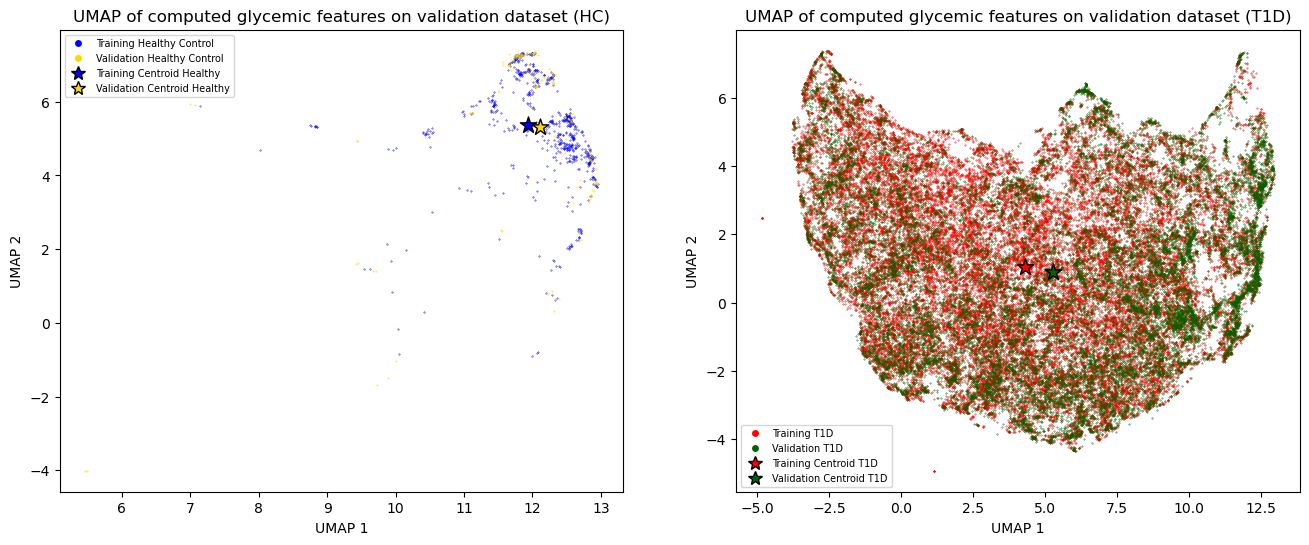

In [15]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
label_val = val.label

train_healthy_color = "blue"
train_T1D_color = "red"

val_healthy_color = "gold"
val_T1D_color = "darkgreen"

# plt.scatter(X_reduced[train_label == 1,0], X_reduced[train_label == 1,1], s=0.1, c="red")
plt.scatter(X_reduced[train_label == 0,0], X_reduced[train_label == 0,1], s=0.1, c=train_healthy_color)
plt.scatter(X_reduced_val[label_val == 0,0], X_reduced_val[label_val == 0,1], s=0.1, c=val_healthy_color)
# plt.scatter(X_reduced_val[label_val == 1,0], X_reduced_val[label_val == 1,1], s=0.1, c="green")

# Calculate and plot filled Convex Hull for the second cluster
points_0 = X_reduced[train_label == 0]
hull_0 = ConvexHull(points_0)
# plt.fill(points_0[hull_0.vertices, 0], points_0[hull_0.vertices, 1], 'blue', alpha=0.1)

# Calculate and plot filled Convex Hull for the second cluster
points_1 = X_reduced_val[label_val == 0]
hull_1 = ConvexHull(points_1)
# plt.fill(points_1[hull_1.vertices, 0], points_1[hull_1.vertices, 1], 'black', alpha=0.1)

# Calculate and plot centroids for each class
centroid_1 = np.mean(points_1, axis=0)
centroid_0 = np.mean(points_0, axis=0)

# Plotting centroids, you can adjust the size (s) and color as needed
plt.scatter(centroid_1[0], centroid_1[1], s=150, c=train_healthy_color, edgecolors="black", marker="*", label='Centroid Healthy val')
plt.scatter(centroid_0[0], centroid_0[1], s=150, c=val_healthy_color, edgecolors="black", marker="*", label='Centroid Healthy train')
print(np.linalg.norm(centroid_1 - centroid_0))

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=train_healthy_color, markersize=3, label='Training Healthy Control'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=val_healthy_color, markersize=3, label='Validation Healthy Control'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=train_healthy_color, markeredgecolor='black', markersize=5, label='Training Centroid Healthy'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=val_healthy_color, markeredgecolor='black', markersize=5, label='Validation Centroid Healthy')]
# Add legend to the plot with custom markers
plt.legend(handles=legend_elements, markerscale=2, fontsize=7)
plt.title("UMAP of computed glycemic features on validation dataset (HC)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.savefig('UMAP for val_control.jpg', format='jpg', dpi=1200)

plt.subplot(1,2,2)
label_val = val.label
plt.scatter(X_reduced[train_label == 1,0], X_reduced[train_label == 1,1], s=0.1, c=train_T1D_color)
# plt.scatter(X_reduced[train_label == 0,0], X_reduced[train_label == 0,1], s=0.1, c="blue")
# plt.scatter(X_reduced_val[label_val == 0,0], X_reduced_val[label_val == 0,1], s=0.1, c="black")
plt.scatter(X_reduced_val[label_val == 1,0], X_reduced_val[label_val == 1,1], s=0.1, c=val_T1D_color)

# Calculate and plot filled Convex Hull for the second cluster
points_0 = X_reduced[train_label == 1]
hull_0 = ConvexHull(points_0)
# plt.fill(points_0[hull_0.vertices, 0], points_0[hull_0.vertices, 1], 'blue', alpha=0.1)

# Calculate and plot filled Convex Hull for the second cluster
points_1 = X_reduced_val[label_val == 1]
hull_1 = ConvexHull(points_1)
# plt.fill(points_1[hull_1.vertices, 0], points_1[hull_1.vertices, 1], 'black', alpha=0.1)

# Calculate and plot centroids for each class
centroid_1 = np.mean(points_1, axis=0)
centroid_0 = np.mean(points_0, axis=0)
print(np.linalg.norm(centroid_1 - centroid_0))

# Plotting centroids, you can adjust the size (s) and color as needed
plt.scatter(centroid_1[0], centroid_1[1], s=150, c=val_T1D_color, edgecolors="black", marker="*", label='Centroid T1D val')
plt.scatter(centroid_0[0], centroid_0[1], s=150, c=train_T1D_color, edgecolors="black", marker="*", label='Centroid T1D Train')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=train_T1D_color, markersize=3, label='Training T1D'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=val_T1D_color, markersize=3, label='Validation T1D'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=train_T1D_color, markeredgecolor='black', markersize=5, label='Training Centroid T1D'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=val_T1D_color, markeredgecolor='black', markersize=5, label='Validation Centroid T1D')
    
]
# Add legend to the plot with custom markers
plt.legend(handles=legend_elements, markerscale=2, fontsize=7)
plt.title("UMAP of computed glycemic features on validation dataset (T1D)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

plt.savefig('UMAP for validation.jpg', format='jpg', dpi=1200, bbox_inches='tight')

plt.show()

### For Centroid Distance for Validation

In [16]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

distance_to_centroid = []
diabetic_or_not = 1
for point in tqdm(X_reduced_val[label_val == diabetic_or_not,:]):
    silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
    distance_to_centroid.append(silhouette_score_single)

100%|███████████████████████████████████████████████████████████████████████████| 22118/22118 [00:52<00:00, 421.09it/s]


In [31]:
filtered_data = np.array(val.loc[label_val == diabetic_or_not,:].HbA1c)
find=~np.isnan(filtered_data)
filtered_data = filtered_data[find]
filtered_distances = np.array(distance_to_centroid)[find]

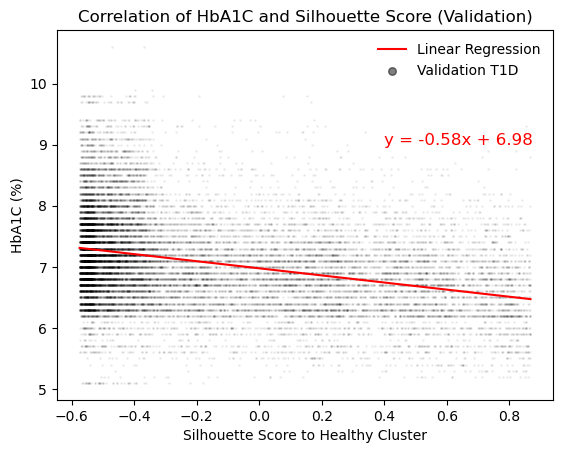

In [32]:
plt.scatter(np.array(distance_to_centroid), val.loc[label_val == diabetic_or_not,:].HbA1c,s=1, c="k",alpha = 0.05)

filtered_data = np.array(val.loc[label_val == diabetic_or_not,:].HbA1c)
find=~np.isnan(filtered_data)
filtered_data = filtered_data[find]
filtered_distances = np.array(distance_to_centroid)[find]
model = LinearRegression()
model.fit(filtered_distances.reshape(-1, 1), filtered_data)

x_range = np.linspace(filtered_distances.min(), filtered_distances.max(), 100).reshape(-1, 1)
y_pred = model.predict(x_range)
plt.plot(x_range, y_pred, color='red', label='Linear Regression')

eq_text = f'y = {model.coef_[0]:.2f}x + {model.intercept_:.2f}'
plt.text(0.4, 9, eq_text, fontsize=12, color='red')

# Add an invisible scatter plot with larger marker size for the legend
plt.scatter([], [], s=30, color='k', alpha=0.5, label="Validation T1D")  # Adjust `s` as needed

plt.xlabel("Silhouette Score to Healthy Cluster")
plt.ylabel("HbA1C (%)")
plt.title("Correlation of HbA1C and Silhouette Score (Validation)")

# Create the legend. You might need to adjust `markerscale` if you use it in conjunction with other markers
plt.legend(frameon=False)
plt.savefig('validation_result.jpg', format='jpg', dpi=1200, bbox_inches='tight')
plt.show()

In [43]:
def pearson_correlation_feature(X_reduced, train_label, train, feature='Age'):
    distance_to_centroid = []
    diabetic_or_not = 0
    for point in tqdm(X_reduced[train_label == diabetic_or_not,:]):
        silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
        distance_to_centroid.append(silhouette_score_single)
    
    df = pd.DataFrame({'distance_to_centroid': distance_to_centroid, feature: train.loc[train_label == diabetic_or_not,:][feature]})
    df = df.dropna()
    correlation, p_value = pearsonr(df['distance_to_centroid'], df[feature])
    print(f"Healthy Pearson's correlation: {np.round(correlation, 4)}, P-value: {p_value}")
    
    distance_to_centroid = []
    diabetic_or_not = 1
    for point in tqdm(X_reduced[train_label == diabetic_or_not,:]):
        silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
        distance_to_centroid.append(silhouette_score_single)
        
    correlation, p_value = pearsonr(distance_to_centroid, train.loc[train_label == diabetic_or_not,:][feature])
    print(f"Diabete Pearson's correlation: {np.round(correlation, 4)}, P-value: {p_value}")

In [44]:
pearson_correlation_feature(X_reduced_val, label_val, val)

100%|███████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 489.11it/s]


Healthy Pearson's correlation: 0.0326, P-value: 0.6664081033498339


100%|███████████████████████████████████████████████████████████████████████████| 22118/22118 [00:37<00:00, 595.70it/s]

Diabete Pearson's correlation: 0.2003, P-value: 6.98397354447857e-199


In [59]:
def pearson_correlation_BMI(X_reduced, train_label, train):
    distance_to_centroid = []
    diabetic_or_not = 0
    for point in tqdm(X_reduced[train_label == diabetic_or_not,:]):
        silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
        distance_to_centroid.append(silhouette_score_single)
    
    df = pd.DataFrame({'distance_to_centroid': distance_to_centroid, 'BMI': train.loc[train_label == diabetic_or_not,:]['BMI']})
    df = df.dropna()
    
    correlation, p_value = pearsonr(df['distance_to_centroid'], df['BMI'])
    print(f"Healthy Pearson's correlation: {np.round(correlation, 4)}, P-value: {p_value}")
    
    distance_to_centroid = []
    diabetic_or_not = 1
    for point in tqdm(X_reduced[train_label == diabetic_or_not,:]):
        silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
        distance_to_centroid.append(silhouette_score_single)
        
    df = pd.DataFrame({'distance_to_centroid': distance_to_centroid, 'Weight': train.loc[train_label == diabetic_or_not,:]['Weight'], 'Height': train.loc[train_label == diabetic_or_not,:]['Height']})
    df = df.dropna()

    BMI = df.Weight/((df.Height/100)**2)
    correlation, p_value = pearsonr(df['distance_to_centroid'], BMI)
    print(f"Diabete Pearson's correlation: {np.round(correlation, 4)}, P-value: {p_value}")

In [60]:
pearson_correlation_BMI(X_reduced_val, label_val, val)

100%|███████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 419.20it/s]


Healthy Pearson's correlation: -0.0636, P-value: 0.40313217512344574


100%|███████████████████████████████████████████████████████████████████████████| 22118/22118 [00:44<00:00, 502.18it/s]

Diabete Pearson's correlation: 0.0356, P-value: 1.2084525586907607e-07


In [61]:
def MWU_test(X_reduced, train_label, train):
    distance_to_centroid = []
    diabetic_or_not = 0
    for point in tqdm(X_reduced[train_label == diabetic_or_not,:]):
        silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
        distance_to_centroid.append(silhouette_score_single)
    diabetic_or_not_data = train.loc[train_label == diabetic_or_not,:]
    
    distance_to_centroid = np.array(distance_to_centroid)
    
    # Example data for two groups
    group1 = distance_to_centroid[diabetic_or_not_data.Gender.values == 'F']  # e.g., data for males
    group2 = distance_to_centroid[diabetic_or_not_data.Gender.values == 'M']  # e.g., data for females
    
    # Perform the independent samples t-test
    t_statistic, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    
    # Print the results
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    
    # Interpretation
    alpha = 0.05  # significance level
    if p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two groups.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two groups.")
    
    ks_stat, ks_p_value = stats.ks_2samp(group1, group2)
    print(f'Kolmogorov-Smirnov Test: statistic={ks_stat}, p-value={ks_p_value}')
    
    
    distance_to_centroid = []
    diabetic_or_not = 1
    for point in tqdm(X_reduced[train_label == diabetic_or_not,:]):
        silhouette_score_single = cal.calculate_silhouette_score(X_reduced, train_label, point, 0)
        distance_to_centroid.append(silhouette_score_single)
    diabetic_or_not_data = train.loc[train_label == diabetic_or_not,:]
    
    distance_to_centroid = np.array(distance_to_centroid)
    
    # Example data for two groups
    group1 = distance_to_centroid[diabetic_or_not_data.Gender.values == 'F']  # e.g., data for males
    group2 = distance_to_centroid[diabetic_or_not_data.Gender.values == 'M']  # e.g., data for females
    
    # Perform the independent samples t-test
    t_statistic, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    
    # Print the results
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    
    # Interpretation
    alpha = 0.05  # significance level
    if p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between the two groups.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two groups.")
    
    ks_stat, ks_p_value = stats.ks_2samp(group1, group2)
    print(f'Kolmogorov-Smirnov Test: statistic={ks_stat}, p-value={ks_p_value}')

In [62]:
MWU_test(X_reduced_val, label_val, val)

100%|███████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 625.35it/s]


T-statistic: 3845.0
P-value: 0.8704051971182475
Fail to reject the null hypothesis: There is no significant difference between the two groups.
Kolmogorov-Smirnov Test: statistic=0.13765701102281466, p-value=0.3331669175868056


100%|███████████████████████████████████████████████████████████████████████████| 22118/22118 [00:43<00:00, 511.16it/s]

T-statistic: 56386693.0
P-value: 1.2172444632590575e-14
Reject the null hypothesis: There is a significant difference between the two groups.
Kolmogorov-Smirnov Test: statistic=0.053459226073601096, p-value=6.396068845995839e-14


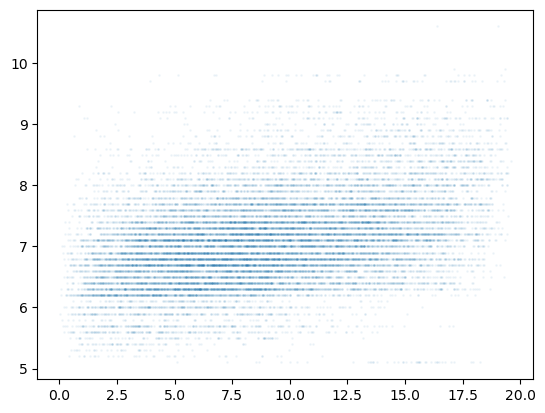

Pearson's correlation: 0.3916322361799095
P-value: 0.0
Spearman's correlation: 0.38239363279822264
P-value: 0.0


In [51]:
distance_to_centroid = []
diabetic_or_not = 1
for point in X_reduced_val[label_val == diabetic_or_not,:]:
    distance_to_centroid.append(np.linalg.norm(point - centroid_healthy))
plt.scatter(np.array(distance_to_centroid), val.loc[label_val == diabetic_or_not,:].HbA1c,s=1, alpha = 0.05)
plt.show()

from scipy.stats import pearsonr
correlation, p_value = pearsonr(distance_to_centroid, val.loc[label_val == diabetic_or_not,:].HbA1c)
print(f"Pearson's correlation: {correlation}")
print(f"P-value: {p_value}")

from scipy.stats import spearmanr
correlation, p_value = spearmanr(distance_to_centroid, val.loc[label_val == diabetic_or_not,:].HbA1c)
print(f"Spearman's correlation: {correlation}")
print(f"P-value: {p_value}")

100%|███████████████████████████████████████████████████████████████████████████| 22116/22116 [00:44<00:00, 500.64it/s]


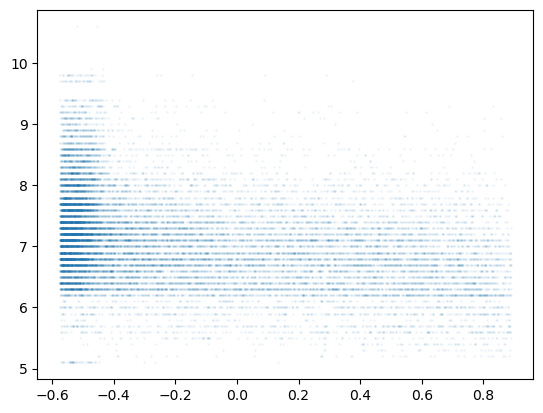

Pearson's correlation: -0.3417233899436064
P-value: 0.0
Spearman's correlation: -0.34712131377966216
P-value: 0.0


In [38]:
distance_to_centroid = []
diabetic_or_not = 1
for point in tqdm(X_reduced_val[label_val == diabetic_or_not,:]):
    silhouette_score_single = calculate_silhouette_score(X_reduced, train_label, point, 0)
    distance_to_centroid.append(silhouette_score_single)
plt.scatter(np.array(distance_to_centroid), val.loc[label_val == diabetic_or_not,:].HbA1c,s=1, alpha = 0.05)
plt.show()

from scipy.stats import pearsonr
correlation, p_value = pearsonr(distance_to_centroid, val.loc[label_val == diabetic_or_not,:].HbA1c)
print(f"Pearson's correlation: {correlation}")
print(f"P-value: {p_value}")

from scipy.stats import spearmanr
correlation, p_value = spearmanr(distance_to_centroid, val.loc[label_val == diabetic_or_not,:].HbA1c)
print(f"Spearman's correlation: {correlation}")
print(f"P-value: {p_value}")

In [52]:
val_result = pd.DataFrame()
val_result["distance_to_centroid"] = distance_to_centroid
val_result["HbA1C"] = np.array(val.loc[label_val == diabetic_or_not,:].HbA1c)

val_result.to_csv("val_result.csv",index=False)

C:\Users\sjfsj\AppData\Local\Temp\ipykernel_4476\3869597124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic["unique_id"] = [number.split('_')[1]+number.split('_')[2] for number in train.id]


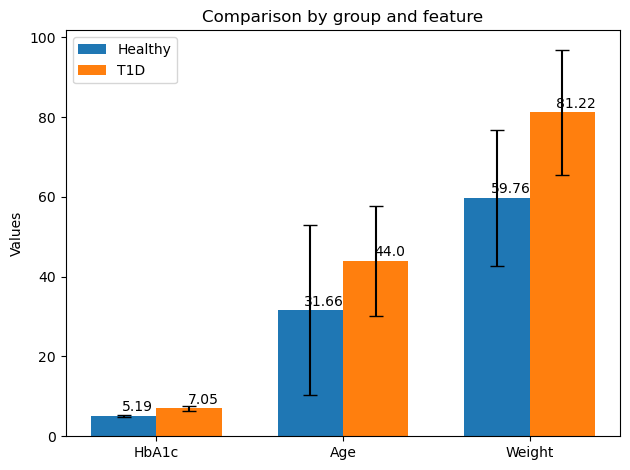

In [80]:
demographic = train[['id','HbA1c', 'Age','Race', 'Gender', 'Weight', 'Height','label']]
demographic["unique_id"] = [number.split('_')[1]+number.split('_')[2] for number in train.id]

T1D_demo = demographic[demographic["label"]==1].groupby("unique_id")
Heal_demo = demographic[demographic["label"]==0].groupby("unique_id")


# Sample data: means and standard deviations for age, weight, and height for Healthy and T1D groups
# For demonstration, replace these with your actual data
features = ['HbA1c', 'Age','Weight']

healthy_means = [np.round(Heal_demo["HbA1c"].mean().mean(), 2),
                 np.round(Heal_demo["Age"].mean().mean(), 2),
                 np.round(Heal_demo["Weight"].mean().mean(), 2)
                 ]  # Example means for the Healthy group
healthy_stds = [Heal_demo["HbA1c"].mean().std(),
                Heal_demo["Age"].mean().std(),
                Heal_demo["Weight"].mean().std(),
                ]  # Example standard deviations for the Healthy group

t1d_means = [np.round(T1D_demo["HbA1c"].mean().mean(), 2),
             np.round(T1D_demo["Age"].mean().mean(), 2),
             np.round(T1D_demo["Weight"].mean().mean(), 2)
             ]
t1d_stds = [T1D_demo["HbA1c"].mean().std(),
            T1D_demo["Age"].mean().std(),
            T1D_demo["Weight"].mean().std()
            ]  # Example standard deviations for the T1D group

# Setting up the x locations for the groups
ind = np.arange(len(features))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, healthy_means, width, yerr=healthy_stds, label='Healthy', capsize=5)
rects2 = ax.bar(ind + width/2, t1d_means, width, yerr=t1d_stds, label='T1D', capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values')
ax.set_title('Comparison by group and feature')
ax.set_xticks(ind)
ax.set_xticklabels(features)
ax.legend()

# Function to attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(10, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
